## Brain Tumor Segementaion using UNet

Dataset Used: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data  

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.
Tumor genomic clusters and patient data is provided in data.csv file.

In [1]:
#Import Necessary libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from tqdm import tqdm

In [2]:
#will use drakbackground style for plotting (images are also with black bg)
plt.style.use("dark_background")

In [3]:
#define dataset folder path
PATH = "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

In [4]:
#create dataframe to store image and mask paths
df = pd.DataFrame()

Each folder contains MR images with the following naming convention:  

```TCGA_<institution-code>_<patient-id>_<slice-number>.tif```  
So, we will use glob to get all mask image paths and then remove "mask" from path to get image path

In [5]:
df["mask_file"] = glob.glob(PATH+"*/*_mask.tif")
df["img_file"] = [path.replace("_mask","") for path in df["mask_file"]]

In [6]:
def get_patient_id(paths):
    """Function to extract patient unique id from mask image path"""
    return [path.split("/")[-2] for path in paths]

In [7]:
#add patient id column to dataframe
df["patient_id"] = get_patient_id(df["mask_file"])

In [8]:
def get_label(path):
    """Check if there is any mask on mask image or not to get label(tumor or not)"""
    mask = Image.open(path)
    mask = np.asarray(mask)
    
    return int(mask.max() > 0)

In [9]:
df["is_tumor"] = df["mask_file"].apply(get_label)

In [10]:
# rearranging columns, just to make it look preetty
df = df.iloc[:,[2,1,0,3]]

In [11]:
df.head()

,patient_id,img_file,mask_file,is_tumor
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,1


In [12]:
#checking if mask path and image paths matches 
rand_idx = torch.randint(1,10,(1,)).item()
df.iloc[rand_idx].values

array(['TCGA_DU_7010_19860307',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif',
       '/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39_mask.tif',
       1], dtype=object)

In [13]:
def random_samples():
    """Function to vizualize random sample of MRI image and corresponding mask"""
    idx = np.random.randint(0, len(df), (2))
    plt.figure(figsize=(5,5))
    
    for i in range(2):
        row = df.iloc[idx[i]]
        plt.subplot(2,2,i*2+1)
        img = Image.open(row["img_file"])
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")    
        
        
        plt.subplot(2,2,i*2+2)
        mask = Image.open(row["mask_file"])
        plt.imshow(mask,cmap="gray")
        plt.title("Mask")
        plt.axis("off")    

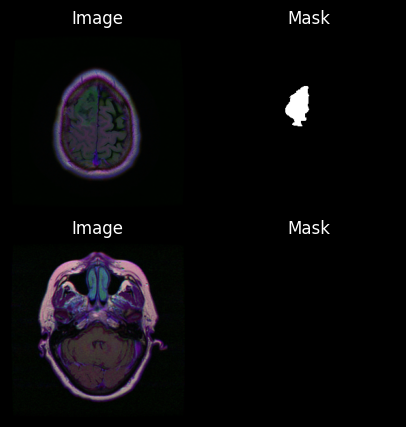

In [14]:
random_samples()

For each patient, there are multiple MRI images and tumor may not be detected in all of them. Let's see number of masks with tumor and without tumor segmentaion for each patient.

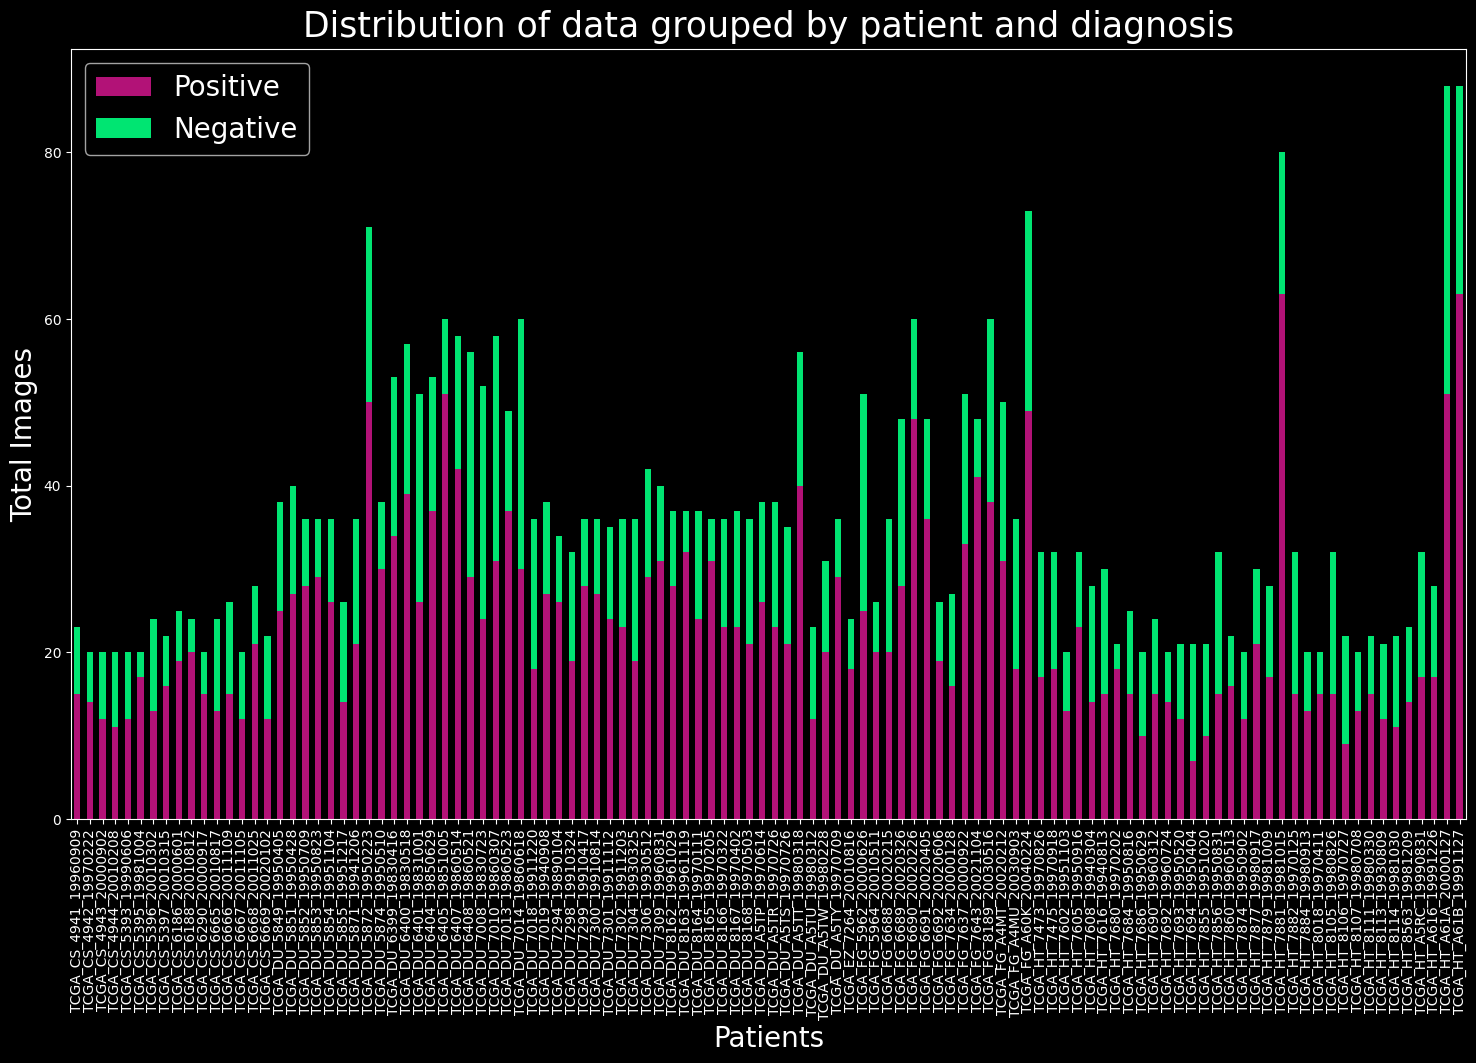

In [15]:
patients_by_diagnosis = df.groupby(['patient_id', 'is_tumor'])['is_tumor'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

plt.show()

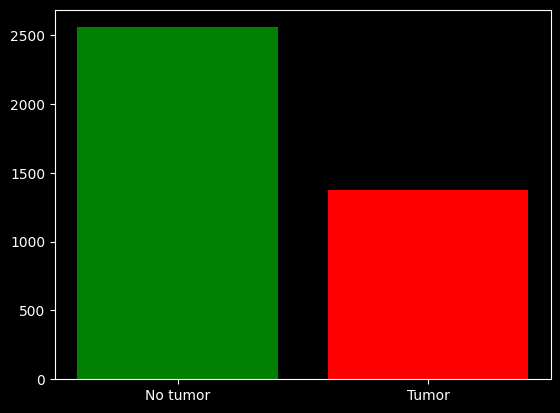

In [16]:
# vizualize number of data with and without tumor
tumor_counts = df["is_tumor"].value_counts()
plt.bar(tumor_counts.index,tumor_counts.values,color=["green","red"])
plt.xticks(range(len(tumor_counts)),["No tumor","Tumor"])
plt.show()

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Create custom transformations so that same transformation can be applied to image,mask pair.

In [18]:
class RandomHFlip():
    """Performs random horizontal flip with given probaility"""
    def __init__(self,p=0.5):
        self.prob = p
    
    def __call__(self, pair):
        img,mask = pair
        if torch.rand((1,)).item() > self.prob:
            img,mask = TF.hflip(img), TF.hflip(mask)
        
        return img,mask

In [19]:
class RandomAffine():
    """Performs random affine transformation(rotate, translate, scaling and shear) with given probaility"""
    def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):
        self.params = {
                'degrees': degrees,
                'translate': translate,
                'scale_ranges': scale_ranges,
                'shears': shears
        }
    
    def __call__(self, pair):
        img, mask = pair
        w, h = img.size
        
        #get parameters for random affine transformations
        angle, translations, scale, shear = transforms.RandomAffine.get_params(self.params['degrees'], self.params['translate'], self.params['scale_ranges'], self.params['shears'], (w,h))
        
        # apply TF.affine using fixed parameters
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        return img, mask


In [20]:
class ToTensorPair():
    """Convert PIL image to tensor, also does normalization"""
    def __call__(self,pair):
        img,mask = pair
        img,mask = transforms.ToTensor()(img), transforms.ToTensor()(mask)
        
        return img,mask

In [21]:
transform = transforms.Compose([
    RandomHFlip(),
    RandomAffine((-10,10),(0.1,0.1),(1,1.3),(-7,7)),
    ToTensorPair()
    
])

In [22]:
class MyDataset(Dataset):
    """Custom dataset to load image pask pair"""
    def __init__(self,df,transform):
        self.images = df["img_file"]
        self.masks = df["mask_file"]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])
        
        image,mask = self.transform((image, mask))
#         mask = self.transform(mask)
        return image,mask

In [23]:
dataset = MyDataset(df,transform)

In [24]:
def show_sample(pair):
    img,mask = pair
    plt.subplot(1,2,1)
    plt.imshow(img.permute(1,2,0))
    
    plt.subplot(1,2,2)
    plt.imshow(mask.permute(1,2,0))

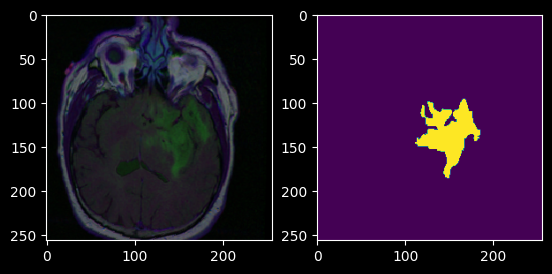

In [25]:
i = torch.randint(1,len(dataset),(1,)).item()
show_sample(dataset[i])

In [26]:
#split dataset into train and validation set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [27]:
BATCH_SIZE = 32

In [28]:
train_loader =  DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=BATCH_SIZE)

First we will experiment with simple UNet architecture with skip connections.  
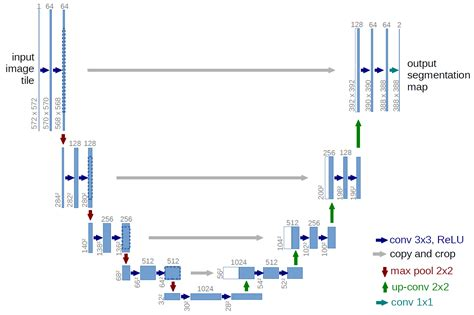

In [29]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv, self).__init__()
            
        self.dconv =  nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
      )
    
    def forward(self,x):
        return self.dconv(x)
    

class Down(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Down, self).__init__()
            
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            DoubleConv(in_channels,out_channels)
      )
    
    def forward(self,x):
        return self.down(x)


class Up(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Up, self).__init__()
            
        self.up = nn.ConvTranspose2d(in_channels,out_channels, kernel_size=(2, 2), stride=(2, 2))
        self.dconv = DoubleConv(in_channels,out_channels)
      
    
    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip), dim=1)
        return self.dconv(x)

In [30]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(3,32)
        self.enc2 = Down(32,64)
        self.enc3 = Down(64, 128)
        self.enc4 = Down(128, 256)
        
        self.bn =  Down(256,512)
        
        self.dec4 = Up(512, 256)
        self.dec3 = Up(256, 128)
        self.dec2 = Up(128, 64)
        self.dec1 = Up(64,32)
        
        self.conv = nn.Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    
    def forward(self,x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        
        bottle = self.bn(enc4)
        
        dec4 = self.dec4(bottle,enc4)
        dec3 = self.dec3(dec4,enc3)
        dec2 = self.dec2(dec3,enc2)
        dec1 = self.dec1(dec2,enc1)
        
        op = self.conv(dec1)
        
        return op

In [31]:
model = UNet()

In [32]:
def train(model,EPOCHS,train_loader,val_loader, criterion,lr = 0.001,):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_n = len(train_loader)

    optimizer = Adam(model.parameters(), lr=lr)
    model = model.to(device)

    train_loss = []
    val_loss = [0]

    for epoch in range(EPOCHS):
        model.train(True)
        pbar = tqdm(train_loader)

        batch_loss = []

        for i,data in enumerate(pbar):
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)
            # Compute the loss and its gradients
            loss = criterion(outputs, labels)
            loss.backward()

            batch_loss.append(loss.item())
            # Adjust learning weights
            optimizer.step()

            pbar.set_description(f"Epoch: {epoch + 1}/{EPOCHS}; Train Loss: {round(np.mean(batch_loss),3)};\
            Val Loss: {round(val_loss[-1],3)};")

          # Set the model to evaluation mode, disabling dropout and using population
          # statistics for batch normalization.
        model.eval()
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            val_batch_loss = []
            for i, vdata in enumerate(val_loader):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels).item()

                val_batch_loss.append(vloss)

        val_loss.append(np.mean(val_batch_loss))
        train_loss.append(np.mean(batch_loss))

    return train_loss,val_loss

In [33]:
EPOCHS = 100

In [34]:
model = UNet()

In [60]:
# train_loss,val_loss  = train(model,EPOCHS,train_loader,val_loader,BCEWithLogitsLoss(),lr=3e-5)

Epoch: 1/100; Train Loss: 0.455;            Val Loss: 0;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]
Epoch: 2/100; Train Loss: 0.366;            Val Loss: 0.416;: 100%|██████████| 99/99 [00:43<00:00,  2.25it/s]
Epoch: 3/100; Train Loss: 0.323;            Val Loss: 0.337;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]
Epoch: 4/100; Train Loss: 0.306;            Val Loss: 0.324;: 100%|██████████| 99/99 [00:43<00:00,  2.28it/s]
Epoch: 5/100; Train Loss: 0.291;            Val Loss: 0.294;: 100%|██████████| 99/99 [00:43<00:00,  2.29it/s]
Epoch: 6/100; Train Loss: 0.283;            Val Loss: 0.285;: 100%|██████████| 99/99 [00:43<00:00,  2.28it/s]
Epoch: 7/100; Train Loss: 0.272;            Val Loss: 0.278;: 100%|██████████| 99/99 [00:43<00:00,  2.27it/s]
Epoch: 8/100; Train Loss: 0.264;            Val Loss: 0.269;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]
Epoch: 9/100; Train Loss: 0.255;            Val Loss: 0.258;: 100%|██████████| 99/99 [00:43<00:00,  2.27it/s]
Epoch: 10/100;

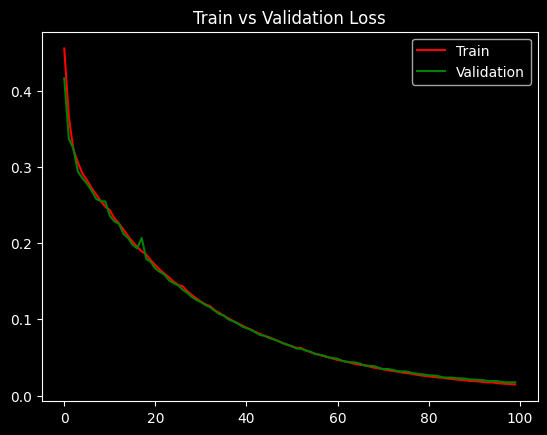

In [67]:
plt.plot(list(range(EPOCHS)),train_loss,c="red")
plt.plot(list(range(EPOCHS)),val_loss[1:],c="green")
plt.legend(["Train","Validation"])
plt.title("Train vs Validation Loss")
plt.show()

In [50]:
model = model.to(device)

In [40]:
def random_pred():
    with torch.no_grad():
        samp = val_dataset[torch.randint(1,400,(1,))[0].item()]
        img = samp[0].to(device)
        mask = samp[1]
        op = model(img.unsqueeze(0)).cpu().squeeze(0)
        op = torch.sigmoid(op)
        op = (op>0.7).int()

        plt.subplot(1,3,1)
        plt.imshow(img.cpu().permute(1,2,0),cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask.permute(1,2,0),cmap="gray")
        plt.title("Original Mask")

        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(op.permute(1,2,0),cmap="gray")
        plt.title("Predicted mask")
        plt.axis("off")
        
        plt.show()

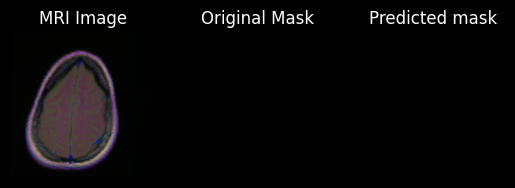

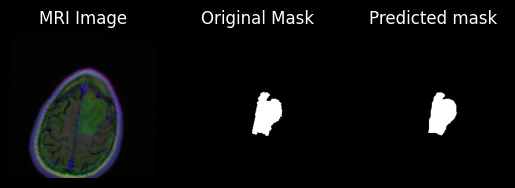

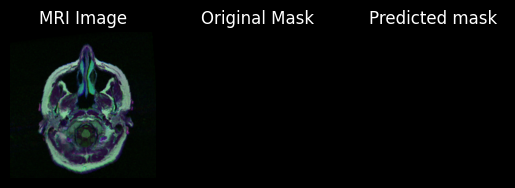

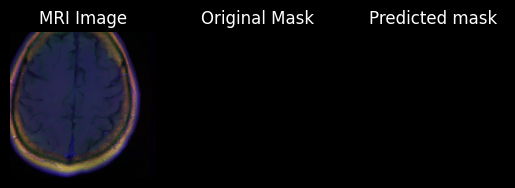

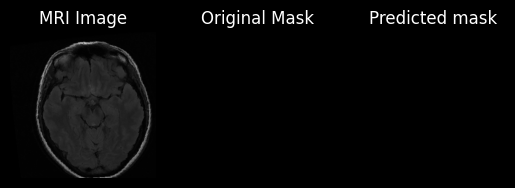

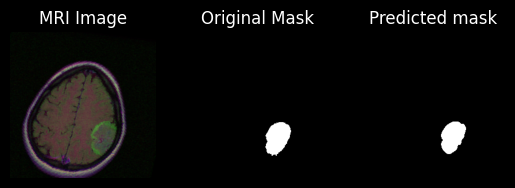

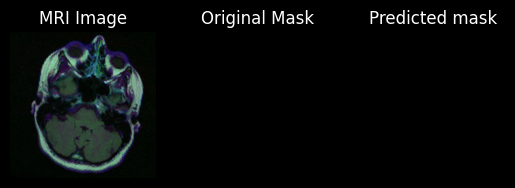

In [71]:
for i in range(7):
    random_pred()

### With Dice Loss

Will use combination of BCE and dice loss as mentioned here: https://medium.com/kaggle-blog/carvana-image-masking-challenge-1st-place-winners-interview-78fcc5c887a8
![image.png](attachment:0e69bc33-3074-4d3f-8c27-2b5eed39ee28.png)

In [44]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        self.bce = BCEWithLogitsLoss() 

    def forward(self, inputs, targets, smooth=1):        
        bce = self.bce(inputs, targets)
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = 1- ((2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth))  
        
        return bce + dice

In [45]:
train_loss2,val_loss2  = train(model,EPOCHS,train_loader,val_loader,DiceLoss(),lr=3e-5)

Epoch: 1/100; Train Loss: 0.148;            Val Loss: 0;: 100%|██████████| 99/99 [00:44<00:00,  2.24it/s]
Epoch: 2/100; Train Loss: 0.145;            Val Loss: 0.176;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]
Epoch: 3/100; Train Loss: 0.14;            Val Loss: 0.167;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s] 
Epoch: 4/100; Train Loss: 0.135;            Val Loss: 0.171;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]
Epoch: 5/100; Train Loss: 0.133;            Val Loss: 0.164;: 100%|██████████| 99/99 [00:44<00:00,  2.24it/s]
Epoch: 6/100; Train Loss: 0.128;            Val Loss: 0.158;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]
Epoch: 7/100; Train Loss: 0.129;            Val Loss: 0.162;: 100%|██████████| 99/99 [00:43<00:00,  2.25it/s]
Epoch: 8/100; Train Loss: 0.127;            Val Loss: 0.161;: 100%|██████████| 99/99 [00:43<00:00,  2.25it/s]
Epoch: 9/100; Train Loss: 0.121;            Val Loss: 0.153;: 100%|██████████| 99/99 [00:43<00:00,  2.26it/s]
Epoch: 10/100;

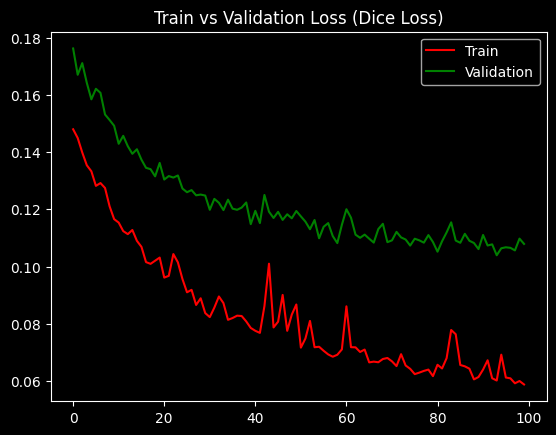

In [46]:
plt.plot(list(range(EPOCHS)),train_loss2,c="red")
plt.plot(list(range(EPOCHS)),val_loss2[1:],c="green")
plt.legend(["Train","Validation"])
plt.title("Train vs Validation Loss (Dice Loss)")
plt.show()

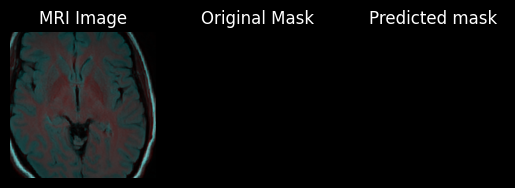

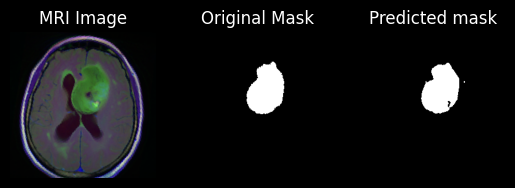

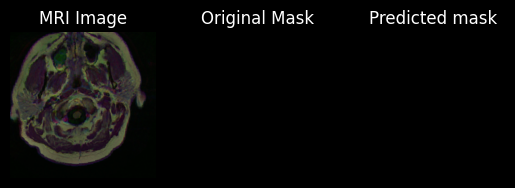

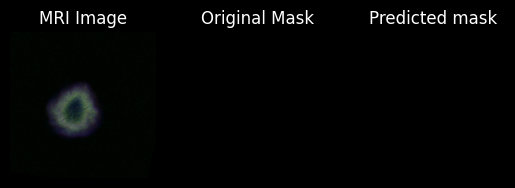

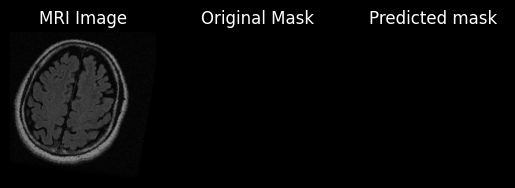

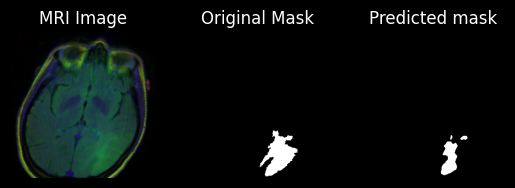

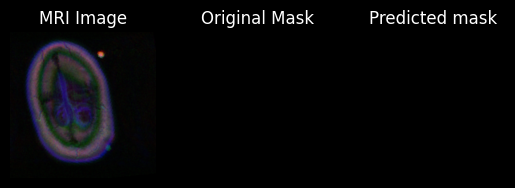

In [49]:
for i in range(7):
    random_pred()